# Part 1

In [60]:
%matplotlib inline
import json
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


In [83]:
times = pd.read_json('logins.json').set_index('login_time')
times['n'] = 1

In [98]:
def _sum(x):
    if len(x) == 0: return 0
    else: return sum(x)


In [102]:
fifteen = times.resample('15T').apply(_sum)
#fifteen.loc[fifteen.n.isnull()]

Below is a view of all the data based on the 15 minute time interval requested. There are definite cycles which I will investigate next.

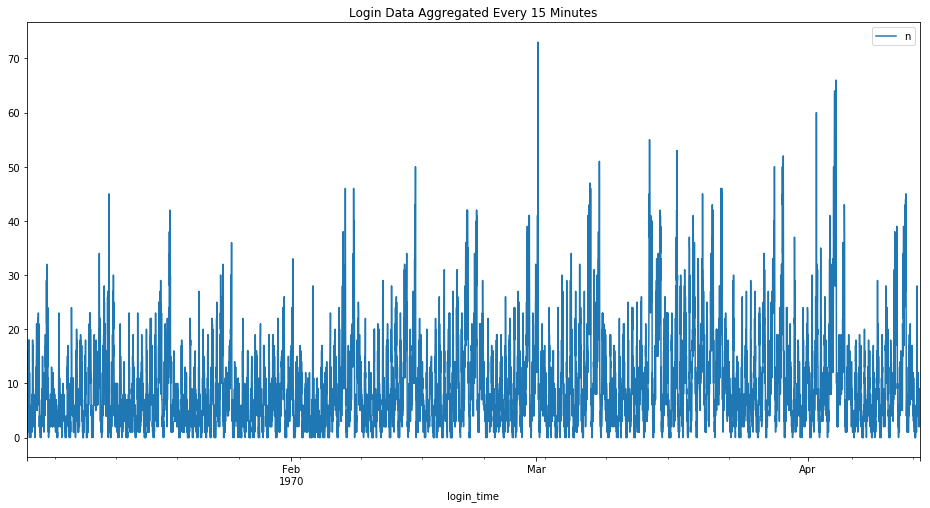

In [127]:
fig,ax = plt.subplots(1,1,figsize=(16,8))
fifteen.plot(ax=ax)
plt.title('Login Data Aggregated Every 15 Minutes')

**Straight away I see an error with the data, or at least an oversight for gathering data for a full analysis, the timestamp has a year value of 1970 which seems quite improbable to be correct. **

Daily cycles in demand fluctuate between 500 and a peak of over 1750 in April.

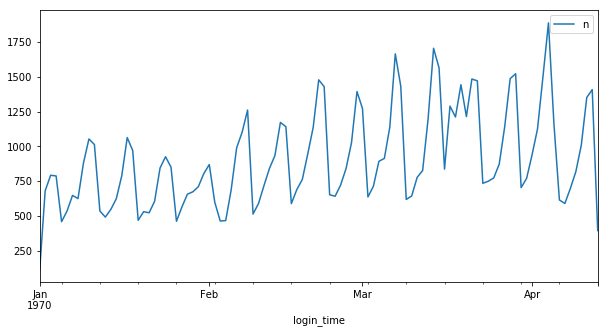

In [137]:
fig,ax = plt.subplots(1,1,figsize=(10,5))
times.resample('1D').sum().plot(ax=ax)

Below we can see the logins by hour for the month of March. We can see the demands spike for 2 days after every 5 days. Looks like the weekend but without proper dates we will have to confirm a different way.

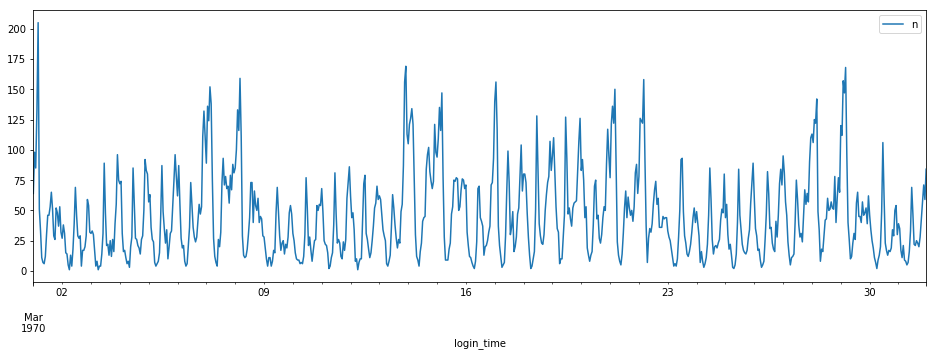

In [145]:
fig,ax = plt.subplots(1,1,figsize=(16,5))
times['1970-03-01':'1970-03-031'].resample('60T').sum().plot(ax=ax)

# Part 2

Since Gotham and Metropolis are most active at different times during the day except on weekends, I would say a measure of success for this toll bridge subsidy should be to see a significant increase in the number of people serviced by partners of one city during the busy time for its opposite. We want to help manage demand during known peak times, and if this plan can be deemed a success, we should see a significant change in drivers patterns during these times. If the managers are not looking to deal with demand issues and just want to encourage flexibility in its partners, then a simpler metric could be adopted where success would be defined as having drivers service the same amount of customers from both cities. In other words, all drivers would still service the same number of people, only the distribution between the cities should drastically change as to almost make the city data indistinguishable from one another.

To test this measure and the experiment overall, I would state that we have two groups. Metropolis and Gotham partners before the change and after the change. For each group I would measure the percentage of their total rides sourced from the oposite's city per week. We would have our baseline computed as to what a few months worth of data (if available) looked like for this test statistic prior to the change. Next we would collect new data and compare each new week and eventually month(s) with this baseline using a permutation test to measure the significance in any difference between the ratios of the two groups. As stated before the goal would be to reach a state where the partners are servicing just as many customers from one city as the other so our weekly testing would not only be looking for significant change but be able to tell us how close to that goal we are getting.

# Part 3


In [188]:
with open('ultimate_data_challenge.json') as file:
    rows=json.loads(file.read()) 
udc = pd.DataFrame.from_records(rows)

In [189]:
udc.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [190]:
udc.last_trip_date = pd.to_datetime(udc.last_trip_date)
udc.last_trip_date.max()

Timestamp('2014-07-01 00:00:00')

**We will define any user who's last_trip_date falls in the month of June or July**

In [191]:
udc['active'] = udc.last_trip_date.apply(lambda x: x.month in [6,7])
udc.active = udc.active.astype(int)

***
## Dealing with Missing Data

In [182]:
udc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
active                    50000 non-null int32
dtypes: bool(1), datetime64[ns](1), float64(6), int32(1), int64(1), object(3)
memory usage: 4.4+ MB


In [219]:
udc = udc.dropna()

In [220]:
udc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41445 entries, 0 to 49998
Data columns (total 13 columns):
avg_dist                  41445 non-null float64
avg_rating_by_driver      41445 non-null float64
avg_rating_of_driver      41445 non-null float64
avg_surge                 41445 non-null float64
city                      41445 non-null object
last_trip_date            41445 non-null datetime64[ns]
phone                     41445 non-null object
signup_date               41445 non-null object
surge_pct                 41445 non-null float64
trips_in_first_30_days    41445 non-null int64
ultimate_black_user       41445 non-null bool
weekday_pct               41445 non-null float64
active                    41445 non-null int32
dtypes: bool(1), datetime64[ns](1), float64(6), int32(1), int64(1), object(3)
memory usage: 4.0+ MB


**82% of users remain after removing any user with a null value**

***


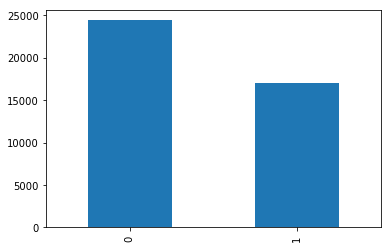

In [221]:
udc.active.value_counts().plot(kind='bar')

In [264]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
rf = RandomForestClassifier()
X = udc[['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge', 'surge_pct', 'trips_in_first_30_days', 'ultimate_black_user', 'weekday_pct']]
y = udc[['active']]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

rf.fit(X_train, y_train.active.values)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=50,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=150, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [265]:
y_train.active.values

array([0, 1, 0, ..., 0, 0, 0])

In [269]:
param_grid = {'n_estimators':[50,150],
             'min_samples_leaf': [50,100]}
clf = GridSearchCV(rf, param_grid, cv=10, verbose=10)
clf.fit(X_train, y_train.active.values)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
[CV] n_estimators=50, min_samples_leaf=50 ............................
[CV]  n_estimators=50, min_samples_leaf=50, score=0.741448, total=   0.6s
[CV] n_estimators=50, min_samples_leaf=50 ............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  n_estimators=50, min_samples_leaf=50, score=0.733525, total=   0.6s
[CV] n_estimators=50, min_samples_leaf=50 ............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=50, min_samples_leaf=50, score=0.747929, total=   0.6s
[CV] n_estimators=50, min_samples_leaf=50 ............................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.5s remaining:    0.0s


[CV]  n_estimators=50, min_samples_leaf=50, score=0.745409, total=   0.6s
[CV] n_estimators=50, min_samples_leaf=50 ............................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.3s remaining:    0.0s


[CV]  n_estimators=50, min_samples_leaf=50, score=0.738207, total=   0.6s
[CV] n_estimators=50, min_samples_leaf=50 ............................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.2s remaining:    0.0s


[CV]  n_estimators=50, min_samples_leaf=50, score=0.730284, total=   0.6s
[CV] n_estimators=50, min_samples_leaf=50 ............................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    5.0s remaining:    0.0s


[CV]  n_estimators=50, min_samples_leaf=50, score=0.743968, total=   0.6s
[CV] n_estimators=50, min_samples_leaf=50 ............................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    5.8s remaining:    0.0s


[CV]  n_estimators=50, min_samples_leaf=50, score=0.746849, total=   0.6s
[CV] n_estimators=50, min_samples_leaf=50 ............................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    6.7s remaining:    0.0s


[CV]  n_estimators=50, min_samples_leaf=50, score=0.734606, total=   0.6s
[CV] n_estimators=50, min_samples_leaf=50 ............................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    7.5s remaining:    0.0s


[CV]  n_estimators=50, min_samples_leaf=50, score=0.732973, total=   0.6s
[CV] n_estimators=150, min_samples_leaf=50 ...........................
[CV]  n_estimators=150, min_samples_leaf=50, score=0.743968, total=   1.9s
[CV] n_estimators=150, min_samples_leaf=50 ...........................
[CV]  n_estimators=150, min_samples_leaf=50, score=0.732445, total=   1.9s
[CV] n_estimators=150, min_samples_leaf=50 ...........................
[CV]  n_estimators=150, min_samples_leaf=50, score=0.747209, total=   2.0s
[CV] n_estimators=150, min_samples_leaf=50 ...........................
[CV]  n_estimators=150, min_samples_leaf=50, score=0.743248, total=   1.9s
[CV] n_estimators=150, min_samples_leaf=50 ...........................
[CV]  n_estimators=150, min_samples_leaf=50, score=0.743608, total=   1.9s
[CV] n_estimators=150, min_samples_leaf=50 ...........................
[CV]  n_estimators=150, min_samples_leaf=50, score=0.727764, total=   1.9s
[CV] n_estimators=150, min_samples_leaf=50 .......

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  1.0min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=50,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=150, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [50, 150], 'min_samples_leaf': [50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=10)

In [271]:
clf.best_params_

{'min_samples_leaf': 50, 'n_estimators': 150}

Looking at this model we can use its most important and critical factors determined to impact retention and develop intiatives around bolstering that part of the business, product, communication, or analysis.